In [1]:
import pandas as pd
import scipy
import nltk
from nltk.corpus import stopwords
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from pymorphy2 import MorphAnalyzer
from string import punctuation, digits
punctuation = set(punctuation + '«»—–…“”\n\t' + digits)

In [2]:
import matplotlib.pylab as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (20, 6)
plt.style.use('ggplot')

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
df = pd.read_csv('metatable.tsv', sep='\t', header=None)
df['tradition']=df[9].str.split('->').str.get(0).apply(lambda x: x.replace('\xad', ''))
df['country']=df[9].str.split('->').str.get(1)

In [5]:
df.groupby(['tradition'])['tradition'].count()

tradition
Американская литература          201
Античная литература               49
Британская литература             21
Европейская литература           543
Латиноамериканская литература     14
Прочая восточная литература        7
Прочая европейская литература     24
Прочая литература                113
Русская литература               499
Скандинавская литература          39
Name: tradition, dtype: int64

In [6]:
df['text'] = ''
for i in df.index:
    with open(df[0][i], 'r') as f:
        df['text'][i] = f.read().replace('\xa0', ' ')

In [7]:
traditions = ['Американская литература', 'Античная литература',
       'Британская литература', 'Европейская литература',
       'Латиноамериканская литература', 'Прочая восточная литература',
       'Прочая европейская литература', 'Прочая литература',
       'Русская литература', 'Скандинавская литература']

In [8]:
texts = [''] * 10
l = [0] * 10

for i in df.index:
    for ind in range(len(traditions)):
        if df['tradition'][i] == traditions[ind]:
            texts[ind] += ' {}'.format(df['text'][i])
            l[ind] += 1
            
df2 = pd.DataFrame(texts, traditions)

In [11]:
def plot_dendrogram(vectorizer, texts, labels, title):
    if vectorizer == 'TF':
        vect = TfidfVectorizer(tokenizer=nltk.word_tokenize,
        preprocessor=None, stop_words=stopwords.words('russian'))
    
    elif vectorizer == 'Count':
        vect = CountVectorizer(tokenizer=nltk.word_tokenize,
        preprocessor=None, stop_words=stopwords.words('russian'))
    
    transformed = scipy.sparse.csr_matrix.toarray(vect.fit_transform(texts))
    res = linkage(transformed, method='complete')

    dendrogram(res, labels=labels, leaf_rotation=90)
    plt.title(vectorizer + '_vectorizer ' + title)
    plt.show()

In [12]:
def lemmatize_text(text, pos=True):
    m = MorphAnalyzer()
    tokens = []
    for word in nltk.word_tokenize(text):
        if len(word) < 2:
            continue
        ana = m.parse(word)[0]
        if pos:
            if ana.normal_form and ana.tag.POS:
                tokens.append(ana.normal_form + '_' + ana.tag.POS)
        else:
            tokens.append(ana.normal_form)
    return tokens

In [13]:
def join_into_texts(lists):
    lemmatized_texts = []
    for lst in lists:
        lemmatized_texts.append(' '.join(lst))
    return lemmatized_texts

In [14]:
table = str.maketrans({ch: ' ' for ch in punctuation})

lemmatized_pos_lists = df2.apply(lambda r: lemmatize_text(r[0].translate(table)), axis=1).values
lemmatized_pos = join_into_texts(lemmatized_pos_lists)

In [15]:
lemmatized_lists = df2.apply(lambda r: lemmatize_text(r[0].translate(table), pos=False), axis=1).values
lemmatized = join_into_texts(lemmatized_lists)

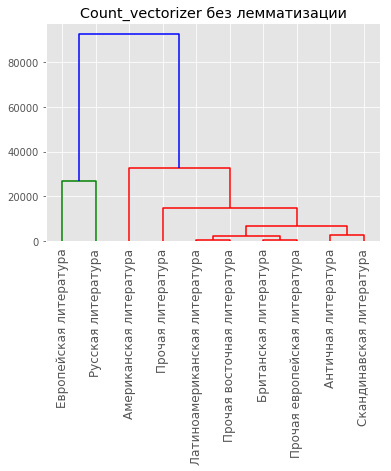

In [16]:
plot_dendrogram('Count', texts, traditions, 'без лемматизации')

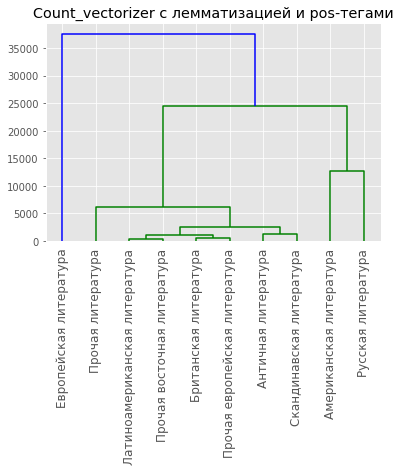

In [17]:
plot_dendrogram('Count', lemmatized_pos, traditions, 'с лемматизацией и pos-тегами')

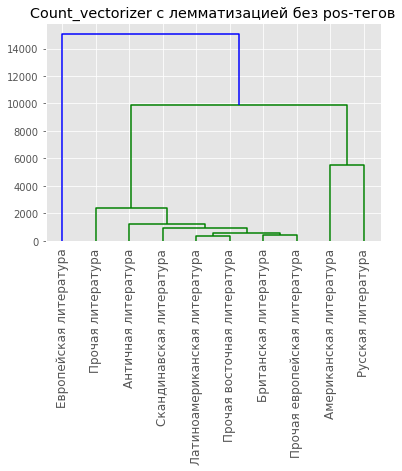

In [18]:
plot_dendrogram('Count', lemmatized, traditions, 'с лемматизацией без pos-тегов')

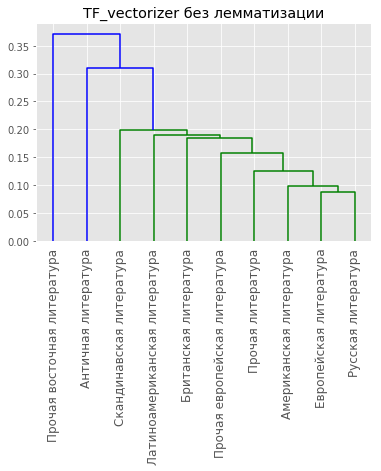

In [19]:
plot_dendrogram('TF', texts, traditions, 'без лемматизации')

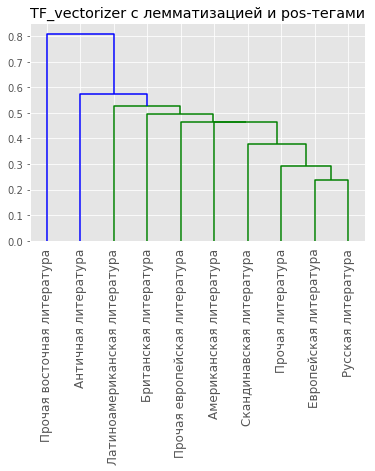

In [20]:
plot_dendrogram('TF', lemmatized_pos, traditions, 'c лемматизацией и pos-тегами')

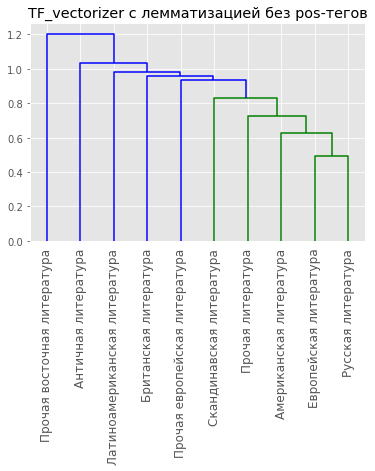

In [21]:
plot_dendrogram('TF', lemmatized, traditions, 'c лемматизацией без pos-тегов')